In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

In [15]:
data = pd.read_excel("default of credit card clients.xls", skiprows = 1)
data.shape

(30000, 25)

In [4]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
#get column names as predictors
Xnames = data.columns.values[1:-1]
Xnames

array([u'LIMIT_BAL', u'SEX', u'EDUCATION', u'MARRIAGE', u'AGE', u'PAY_0',
       u'PAY_2', u'PAY_3', u'PAY_4', u'PAY_5', u'PAY_6', u'BILL_AMT1',
       u'BILL_AMT2', u'BILL_AMT3', u'BILL_AMT4', u'BILL_AMT5',
       u'BILL_AMT6', u'PAY_AMT1', u'PAY_AMT2', u'PAY_AMT3', u'PAY_AMT4',
       u'PAY_AMT5', u'PAY_AMT6'], dtype=object)

In [28]:
#create train/test mask
itrain, itest = train_test_split(xrange(data.shape[0]), train_size=0.6)
mask=np.ones(data.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [8]:
#optimizing cv

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

#set parameters
parameters = {"n_estimators": range(1, 20)}
clfForest = RandomForestClassifier()

clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       data, Xnames, 'default payment next month', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')   

C:\Users\Alvin\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


using mask
BEST {'n_estimators': 19} 0.470944423098 [mean: 0.38130, std: 0.01211, params: {'n_estimators': 1}, mean: 0.32306, std: 0.01447, params: {'n_estimators': 2}, mean: 0.41016, std: 0.02220, params: {'n_estimators': 3}, mean: 0.37672, std: 0.02424, params: {'n_estimators': 4}, mean: 0.44319, std: 0.02313, params: {'n_estimators': 5}, mean: 0.40175, std: 0.03101, params: {'n_estimators': 6}, mean: 0.44875, std: 0.02399, params: {'n_estimators': 7}, mean: 0.41374, std: 0.02122, params: {'n_estimators': 8}, mean: 0.45613, std: 0.02829, params: {'n_estimators': 9}, mean: 0.42421, std: 0.02139, params: {'n_estimators': 10}, mean: 0.46063, std: 0.03033, params: {'n_estimators': 11}, mean: 0.43094, std: 0.02507, params: {'n_estimators': 12}, mean: 0.46063, std: 0.01938, params: {'n_estimators': 13}, mean: 0.44327, std: 0.02375, params: {'n_estimators': 14}, mean: 0.46388, std: 0.02598, params: {'n_estimators': 15}, mean: 0.44408, std: 0.02553, params: {'n_estimators': 16}, mean: 0.4657

![hwimages](./images/confusionmatrix.png)
When building machine learning models, there will always be inaccuracies.  In some cases, however, the kind of inaccuracy matters.  For example, if you are trying to predict if a patient has cancer, the model will need to be more conservative and should lean towards classifying patients as having cancer versus not having it -- this means having more False Positives than False Negatives).   In this case, do false positives and false negatives matter?  Credit companies would want to charge customers with a higher probability of default a higher premium.  This means that evaluating the probability would be more useful than the classification itself.  Let's do that.

In [21]:
#optimizing cv

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_proba(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    predictions = clf.predict_proba(Xtest)
    return predictions

In [24]:
probs = do_proba(clfForest, parameters, data, Xnames, 'default payment next month', 1, mask=mask, n_jobs = 4, score_func='f1')


C:\Users\Alvin\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


using mask
BEST {'n_estimators': 19} 0.471532507346 [mean: 0.38933, std: 0.01431, params: {'n_estimators': 1}, mean: 0.32692, std: 0.02516, params: {'n_estimators': 2}, mean: 0.42392, std: 0.02138, params: {'n_estimators': 3}, mean: 0.37582, std: 0.02486, params: {'n_estimators': 4}, mean: 0.44035, std: 0.01272, params: {'n_estimators': 5}, mean: 0.40700, std: 0.03318, params: {'n_estimators': 6}, mean: 0.44973, std: 0.02957, params: {'n_estimators': 7}, mean: 0.42120, std: 0.01132, params: {'n_estimators': 8}, mean: 0.45755, std: 0.02730, params: {'n_estimators': 9}, mean: 0.42906, std: 0.02361, params: {'n_estimators': 10}, mean: 0.45702, std: 0.02641, params: {'n_estimators': 11}, mean: 0.43463, std: 0.02705, params: {'n_estimators': 12}, mean: 0.45439, std: 0.02955, params: {'n_estimators': 13}, mean: 0.44501, std: 0.02241, params: {'n_estimators': 14}, mean: 0.45980, std: 0.02702, params: {'n_estimators': 15}, mean: 0.44937, std: 0.02689, params: {'n_estimators': 16}, mean: 0.4643

## Relative Importance

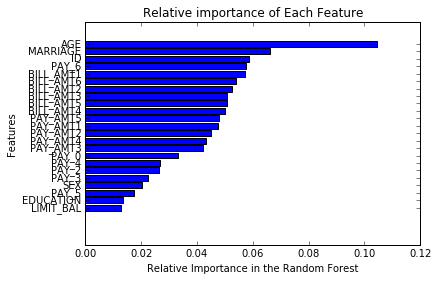

In [13]:
importance_list = clfForest.feature_importances_
name_list = data.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

In [25]:
probs

array([[ 0.42105263,  0.57894737],
       [ 0.73684211,  0.26315789],
       [ 0.84210526,  0.15789474],
       ..., 
       [ 0.47368421,  0.52631579],
       [ 1.        ,  0.        ],
       [ 0.89473684,  0.10526316]])